<a href="https://colab.research.google.com/github/majdkhalife/StockPredictor/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup env

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

## Choose stock and plot opening and closing prices

In [2]:
stock_data = yf.download("NVDA", start="2023-08-01")
get_stock_data = pd.DataFrame(stock_data)

[*********************100%***********************]  1 of 1 completed


In [3]:
get_stock_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2023-08-01,46.485901,46.507000,46.900002,46.027000,46.459999,237858000
2023-08-02,44.248920,44.269001,45.840000,43.387001,45.831001,530142000
2023-08-03,44.494804,44.514999,45.118000,43.799999,43.799999,324176000
2023-08-04,44.659729,44.680000,45.641998,44.393002,44.985001,362666000
2023-08-07,45.396397,45.417000,45.540001,44.563000,45.111000,322154000


In [4]:
get_stock_data = get_stock_data.reset_index()
get_stock_data = get_stock_data[["Date","Open", "Close"]]

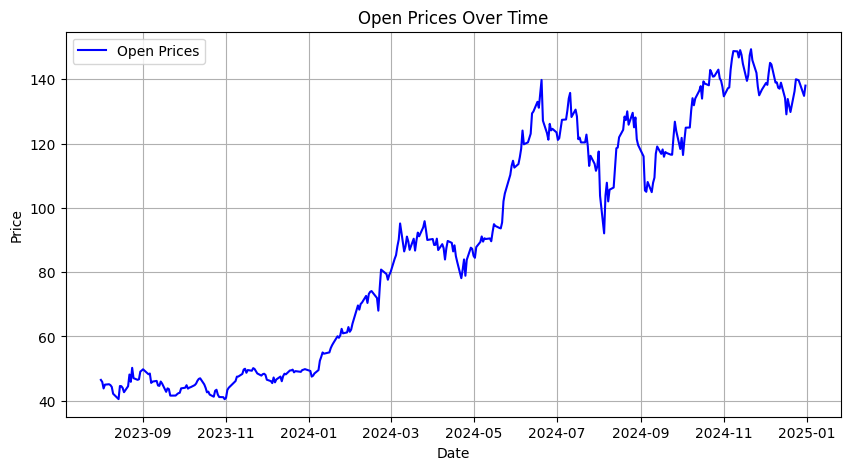

In [5]:
# Plot Open values
plt.figure(figsize=(10, 5))
plt.plot(get_stock_data['Date'], get_stock_data["Open"], label="Open Prices", color="blue")
plt.title("Open Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

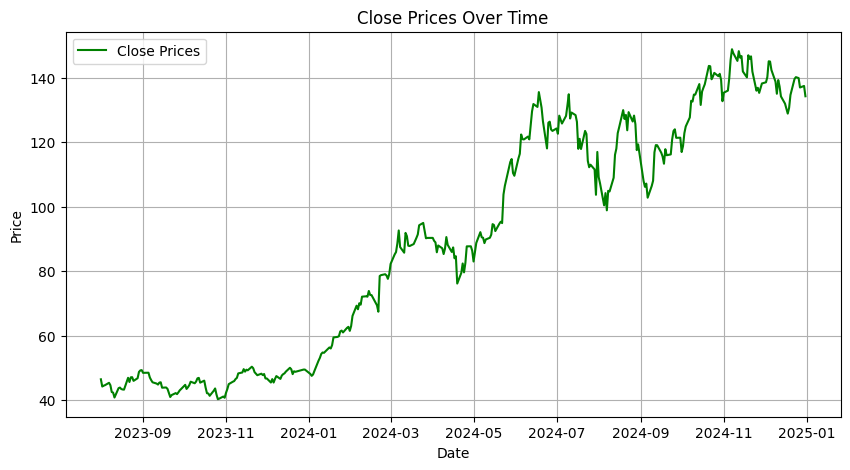

In [6]:
# Plot Open values
plt.figure(figsize=(10, 5))
plt.plot(get_stock_data['Date'], get_stock_data["Close"], label="Close Prices", color="green")
plt.title("Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

## Preprocess data

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(get_stock_data[["Open", "Close"]])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_data, scaled_data, test_size=0.2, shuffle=False)

## Create sequence

In [9]:
def create_sequence(data, sequence_length=365):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  # Sequence of past 50 days
        label = data[i + sequence_length]  # Value to predict (day 51)
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

train_seq, train_label = create_sequence(X_train, sequence_length=50)
test_seq, test_label = create_sequence(X_test, sequence_length=50)

train_seq = train_seq.reshape((train_seq.shape[0], train_seq.shape[1], 2))
test_seq  = test_seq.reshape((test_seq.shape[0], test_seq.shape[1], 2))

## Define model

In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_seq.shape[1], train_seq.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=2))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,102 (199.62 KB)

 Trainable params: 51,102 (199.62 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#7) Early stopping
class LossThresholdCallback(Callback):
    def __init__(self, threshold=0.0001):
        super(LossThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")
        if current_loss is not None:
            if current_loss < self.threshold:
                print(f"\nTraining stopped because loss < {self.threshold:.6f}")
                self.model.stop_training = True


In [12]:
loss_threshold_cb = LossThresholdCallback(threshold=0.0005)  # Adjust threshold as needed
model.fit(
    train_seq,
    train_label,
    epochs=100,
    validation_data=(test_seq, test_label),
    verbose=1,
    callbacks=[loss_threshold_cb]
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0850 - val_loss: 0.0280
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0231 - val_loss: 0.0258
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0140 - val_loss: 0.0122
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0104 - val_loss: 0.0116
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0078 - val_loss: 0.0045
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0070 - val_l

## Make predictions

In [13]:
test_pred = model.predict(test_seq)
test_inverse_pred = scaler.inverse_transform(test_pred)

stock_pred_data = get_stock_data.iloc[-len(test_pred):].copy()
stock_pred_data['Predicted_Open'] = test_inverse_pred[:, 0]
stock_pred_data['Predicted_Close'] = test_inverse_pred[:, 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


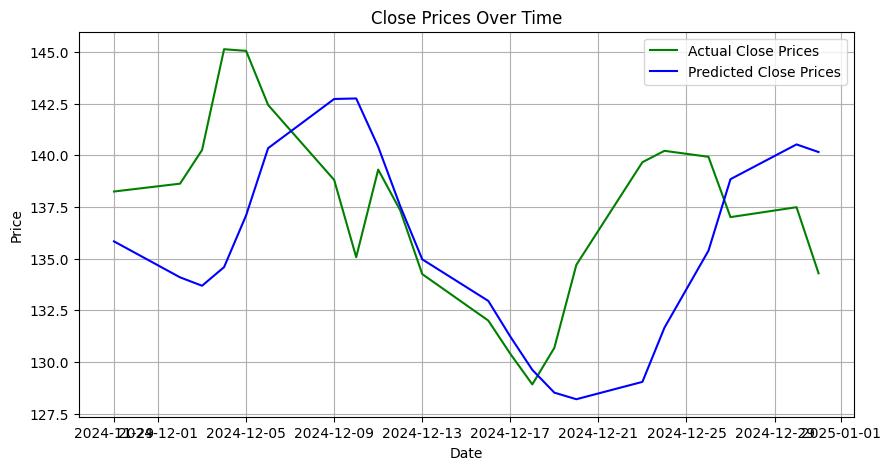

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(get_stock_data["Date"][-len(stock_pred_data["Predicted_Close"]):],
         get_stock_data["Close"][-len(stock_pred_data["Predicted_Close"]):],
         label="Actual Close Prices", color="green")
plt.plot(get_stock_data["Date"][-len(stock_pred_data["Predicted_Close"]):],
         stock_pred_data["Predicted_Close"],
         label="Predicted Close Prices", color="blue")
plt.title("Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

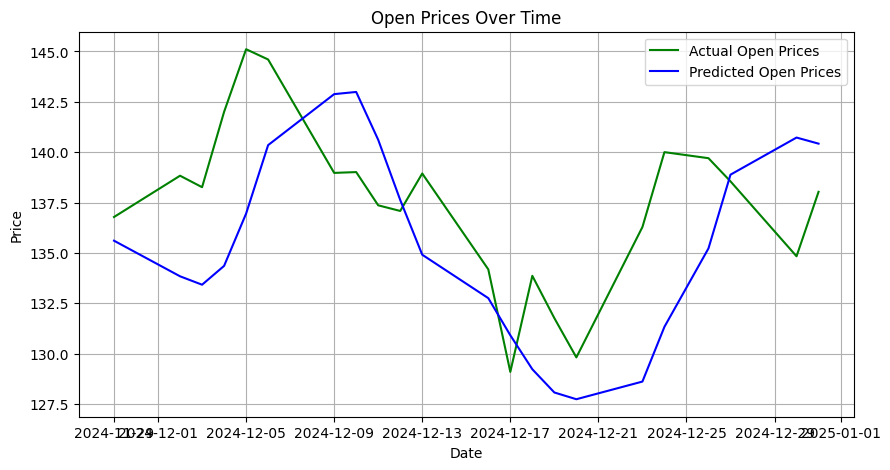

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(get_stock_data["Date"][-len(stock_pred_data["Predicted_Open"]):],
         get_stock_data["Open"][-len(stock_pred_data["Predicted_Open"]):],
         label="Actual Open Prices", color="green")
plt.plot(get_stock_data["Date"][-len(stock_pred_data["Predicted_Open"]):],
         stock_pred_data["Predicted_Open"],
         label="Predicted Open Prices", color="blue")
plt.title("Open Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

In [16]:
actual_close = get_stock_data["Close"][-len(stock_pred_data["Predicted_Close"]):].values
predicted_close = stock_pred_data["Predicted_Close"].values

predicted_close = predicted_close.reshape(-1, 1)

correlation_close = np.corrcoef(actual_close.flatten(), predicted_close.flatten())[0, 1]  # flatten for 1D
mae_close = mean_absolute_error(actual_close, predicted_close)

print(f"Correlation (Actual vs. Predicted Close): {correlation_close:.4f}")
print(f"Mean Absolute Error (MAE) for Close:       {mae_close:.4f}")

Correlation (Actual vs. Predicted Close): 0.3448
Mean Absolute Error (MAE) for Close:       4.2468


In [17]:
def predict_future(model, scaler, last_sequence, days=15):
    """
    Predict future prices for `days` days based on the last_sequence.
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        pred = model.predict(current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1]))
        future_predictions.append(pred[0])

        # Shift the window: remove the first day, append the new prediction
        current_sequence = np.append(current_sequence[1:], pred, axis=0)

    future_predictions = np.array(future_predictions)
    future_predictions = scaler.inverse_transform(future_predictions)  # invert scaling
    return future_predictions

# Grab the last sequence from test set
last_sequence = test_seq[-1]

# Predict for the next 10 days
future_days = 15
future_preds_10 = predict_future(model, scaler, last_sequence, days=future_days)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


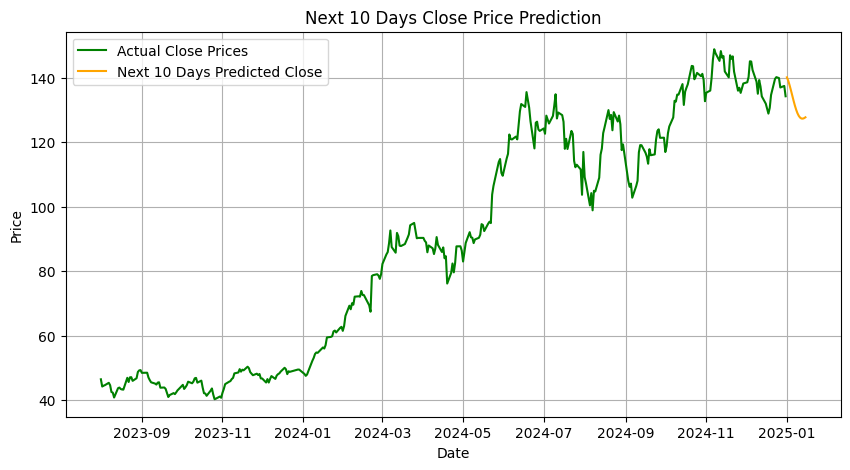

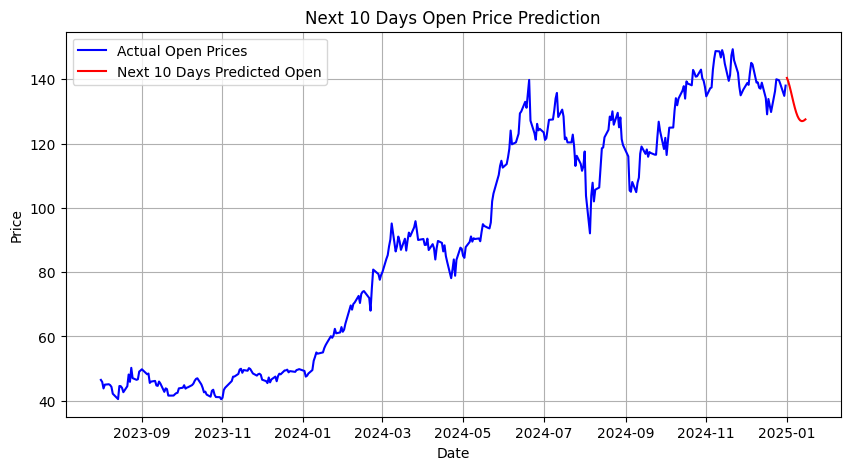

In [18]:
last_date = get_stock_data["Date"].iloc[-1]  # last date in dataset
future_dates_10 = pd.date_range(start=last_date, periods=future_days+1, freq='D')[1:]
future_data_10 = pd.DataFrame(future_preds_10, columns=["Future_Open", "Future_Close"])
future_data_10["Date"] = future_dates_10

plt.figure(figsize=(10, 5))
plt.plot(get_stock_data["Date"], get_stock_data["Close"], label="Actual Close Prices", color="green")
plt.plot(future_data_10["Date"], future_data_10["Future_Close"], label="Next 10 Days Predicted Close", color="orange")
plt.title("Next 10 Days Close Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(get_stock_data["Date"], get_stock_data["Open"], label="Actual Open Prices", color="blue")
plt.plot(future_data_10["Date"], future_data_10["Future_Open"], label="Next 10 Days Predicted Open", color="red")
plt.title("Next 10 Days Open Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()